This notebook is for re-running the isolated subwindows due to their predictions being absurd and not giving the expected results. But we may also need to keep track of the inferences for these subwindows so we know we are getting the required output. Why this is not submitted as a job is because individual scripts will limit the number of jobs we can do. Actually, we might need to store all this work somewhere, we might else loose access.

In [1]:
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import os
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
import concurrent.futures
from tqdm import tqdm

2025-09-24 22:04:31.580614: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-24 22:04:31.609867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

In [3]:
# Split the data into train and test data

def split_train_test_data(sub_image_df, path_to_df, n_forecasting):
    # join the paths
    complete_path_to_df = os.path.join(path_to_df, sub_image_df)
    # read the csv 
    read_df = pd.read_csv(complete_path_to_df)

    # split the data into train and test
    train_df = read_df.iloc[:-n_forecasting, :]
    print(train_df.shape)
    test_df = read_df.iloc[-n_forecasting:,:]
    print(test_df.shape)

    # get the obs data
    train_y = np.log(train_df['density'] + 1)
    test_y = np.log(test_df['density'] + 1)

    # make these float 32 for bayes ts implementation
    train_y = train_y.astype("float32")
    test_y = test_y.astype("float32")

    # these needs to be returned

    # also split the covariate data
    # but add an intercept before the split?
    read_df.insert(0, 'intercept', np.repeat(1, read_df.shape[0]))
    # make this float32 for bayes ts implementation
    read_df['intercept'] = read_df['intercept'].astype("float32")

    # now can extract the covariate data
    X_preds = read_df.drop(['density'], axis = 1).astype("float32")
    X_preds = X_preds.values
    print(X_preds.shape)
    n_preds = X_preds.shape[-1]
    return(train_y, test_y, X_preds, n_preds) 


In [4]:
# redefine the plot function
def plot_tassel_count_data(train_data, test_data, df_no, fig, ax):
    # if not fig_ax:
    #     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # else:
    #     fig, ax = fig_ax
    ax.plot(train_data, color = 'blue', label="training data")
    ax.plot(test_data, color = 'lightcoral', label="testing data")
    ax.legend()
    ax.set(
        ylabel="Tassel counts" ,
        xlabel="Time",
        title = "Tassel count distribution for sub image " + str(df_no)
    )
    fig.autofmt_xdate()
    fig.show()
    return fig, ax

In [5]:
def get_prioirs_and_x_beta(X_pred, n_pred):
    beta = yield root(tfd.Sample(
        tfd.Normal(0., 0.1),
        sample_shape=n_pred,
        name='beta'))
    x_beta = tf.einsum('ij,...j->...i', X_pred, beta)

    noise_sigma = yield root(tfd.HalfNormal(scale=1, name='noise_sigma'))

    intercept_data = X_pred[:,0]

    return (x_beta, intercept_data, noise_sigma)

In [6]:
train_tp = 13

def generate_model_ar_latent(preds_data, n_pred, training=True):

    @tfd.JointDistributionCoroutine # Used when defining the join distribution - we define the joint distribution in the function below
    def model_with_latent_ar():
        # we get the x_beta, intercept and the priors for noise sigma from the function defined earlier
        x_beta, intercept_data, noise_sigma = yield from get_prioirs_and_x_beta(preds_data, n_pred)

        # define the latent AR component as before
        # Latent AR(1)
        # define the two priors for the parameters of the AR(1) process
        ar_sigma = yield root(tfd.HalfNormal(0.1, name='ar_sigma'))
        rho = yield root(tfd.Uniform(0.3, 1., name='rho'))

        # define the AR function below
        def ar_fun(y):
            loc = tf.concat([tf.zeros_like(y[..., :1]), y[..., :-1]],
                            axis=-1) * rho[..., None]
            return tfd.Independent(
                tfd.Normal(loc=loc, scale=ar_sigma[..., None]),
                reinterpreted_batch_ndims=1)
        temporal_error = yield tfd.Autoregressive(
            distribution_fn=ar_fun,
            sample0=tf.zeros_like(intercept_data),
            num_steps=intercept_data.shape[-1],
            name='temporal_error')

        # Linear prediction - note we add the X_beta and the temporal error to get y_hat: and we need the part of if training as we input all data at once and we only want
        # train data to be used for the model training
        y_hat = x_beta + temporal_error
        if training:
            y_hat = y_hat[..., :train_tp]

        # Likelihood
        observed = yield tfd.Independent(
            tfd.Normal(y_hat, noise_sigma[..., None]),
            reinterpreted_batch_ndims=1,
            name='observed'
        )


    # not sure wy we are returning the defined model though
    return model_with_latent_ar


In [7]:
# define a function to plot the X_beta and temporal errors - note we are only choosing the last 100 values in each chain for the plot
def preds_and_temoral_error(mcmc_samples_data, preds_data, n_total_time_points, nchains):
    # plot components
    fig, ax = plt.subplots(2, 1, figsize=(10, 7.5), sharex=True)

    beta = mcmc_samples_data[0]
    seasonality_posterior = tf.einsum('ij,...j->...i', preds_data, beta)
    temporal_error = mcmc_samples_data[-1]

    for i in range(nchains):
        ax[0].plot(np.arange(n_total_time_points), seasonality_posterior[-100:, i, :].numpy().T, alpha=.05);
        ax[1].plot(np.arange(n_total_time_points), temporal_error[-100:, i, :].numpy().T, alpha=.05);

    ax[0].set_title('X_beta effect')
    ax[1].set_title('Temporal error')
    ax[1].set_xlabel("Day")
    fig.autofmt_xdate()

In [8]:
# Plot the forecated and actual values - some 250 forecasted values, their averages, and the true values at all time points.
def forecasted_and_actual_values_plot(ppc_sample_data, train_counts, test_counts, df_no, fig, ax):
    fitted_with_forecast = ppc_sample_data[-1].numpy()
    
    ax.plot(np.arange(20), fitted_with_forecast[:250, 0, :].T, color='gray', alpha=.1);
    ax.plot(np.arange(20), fitted_with_forecast[:250, 1, :].T, color='gray', alpha=.1);
    
    plot_tassel_count_data(train_counts, test_counts, df_no, fig, ax)
    average_forecast = np.mean(fitted_with_forecast, axis=(0, 1)).T
    ax.plot(np.arange(20), average_forecast, ls='--', label='latent AR forecast', color = 'red', alpha=.5);
    plt.xticks(np.arange(20))
    plt.legend()
    plt.show()

In [9]:
# create a function to get the posteriors and the trace plots with az - for all model parameters
def get_nuts_values_and_posterior_plots(mcmc_samples_bts, sampler_stats_bts):
    nuts_trace_ar_latent = az.from_dict(posterior={k:np.swapaxes(v.numpy(), 1, 0) for k, v in mcmc_samples_bts._asdict().items()},
    sample_stats = {k:np.swapaxes(sampler_stats_bts[k], 1, 0)for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]})

    axes = az.plot_trace(nuts_trace_ar_latent, var_names=['beta', 'ar_sigma', 'rho', 'noise_sigma'], compact=True);

    plt.tight_layout()
    return(nuts_trace_ar_latent)

In [10]:
# This function returns all posterior values (distributions) for model parameters
def posterior_vals(nuts_model):
    rho_values = nuts_model.posterior.rho
    print(rho_values.shape)
    ar_sigma_values = nuts_model.posterior.ar_sigma
    print(ar_sigma_values.shape)
    noise_sigma_values = nuts_model.posterior.noise_sigma
    print(noise_sigma_values.shape)
    beta_vals_all = nuts_model.posterior.beta
    print(beta_vals_all.shape)

    return(rho_values, ar_sigma_values, noise_sigma_values, beta_vals_all)

In [11]:
# colors for traceplots
color_list = ['cornflowerblue', 'lightsteelblue', 'blue', 'mediumblue', 'cyan', 'deepskyblue', 'steelblue', 'dodgerblue', 'lightslategray', 'mediumslateblue',
             'lightblue', 'teal', 'royalblue', 'indianred', 'deepskyblue', 'honeydew', 'lightseagreen', 'turquoise', 'cadetblue', 'tan', 'moccasin', 'burlywood',
             'peachpuff', 'powderblue', 'mediumaquamarine', 'powderblue', 'thistle', 'lavender', 'lightcyan', 'darkseagreen', 'honeydew', 'lightsteelblue', 'cadetblue']
len(color_list)

33

In [12]:
# color palattes for freq polygons
color_palletes_betas = ['Greys','Purples','Blues','Greens','Oranges','Reds','YlOrBr','YlOrRd','OrRd','PuRd','RdPu','BuPu','GnBu','PuBu','YlGnBu',
 'PuBuGn','BuGn','YlGn','Greys','Purples','Blues','Greens','Oranges','Reds','YlOrBr','YlOrRd','OrRd','PuRd','RdPu','BuPu','GnBu','PuBu', 'YlGnBu']
len(color_palletes_betas)

33

In [13]:
def get_trace_plots(ax, param, color, string_params):
    ax.plot(param.T, color = color, alpha = 0.5)
    ax.set_title("Trace plot for " + string_params, fontsize=10, fontweight="bold")

# Create a function for this?
def get_freq_curves(ax, param, color_palette, string_params):
    sns.kdeplot(data=param.T, fill=False, ax=ax, legend = False, palette = color_palette)
    ax.set_title("Frequency plot for " + string_params, fontsize=10, fontweight="bold")

In [14]:
def fit_Bayes_TS_model(csv_file, forecasting_steps, path_to_preprocessed_dfs, sub_image_number, n_features, figure_folder_path, forecasts_folder_path, nchains):
    
    ############ We understand the code chunks below #############
    # get the counts and predictors
    Train_Y, Test_Y, X_preds_only, n_predictors = split_train_test_data(csv_file, path_to_preprocessed_dfs, forecasting_steps)
    # plot the train and test counts
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plot_tassel_count_data(Train_Y, Test_Y, sub_image_number, fig, ax)
    # define the mcmc function - we will be using this in a bit - we are using the adaptive nuts HMC method for getting the posterior distributions and predictions
    run_mcmc = tf.function(tfp.experimental.mcmc.windowed_adaptive_nuts , autograph=False, jit_compile=True)
    # define the latet ar model
    gam_with_latent_ar = generate_model_ar_latent(X_preds_only, n_predictors, training=True)
    # plot samples from prior predictive distribution  - we haven't defined a function previously for this
    plt.figure(figsize = (10,8))
    plt.plot(tf.transpose(gam_with_latent_ar.sample(500)[-1]))
    plt.show()
    # run the mcmc with nuts sampler - run for 1000 more steps after a 1000 burning period
    # mcmc_samples - this has all the posterior distributions for the parameters of the model - beta, rho, ar_sigma, noise_sigma and temporal errors
    # sampler_stats - this carries variaous information about the NUTs sampler -  about convergenece steps etc
    mcmc_samples, sampler_stats = run_mcmc(1000, gam_with_latent_ar, n_chains=4, num_adaptation_steps=1000, seed=tf.constant([12541, 2984566], dtype=tf.int32), observed=Train_Y.T)
    # get the posterior values for parameters and the posterioir predictions

    # Why we do this again - maybe as we would like to get predictions for the entire time period and not just the test dataset (The predicted values - for the targets)
    gam_with_latent_ar_full = generate_model_ar_latent(X_preds_only, n_predictors, training=False)
    # below, we get the posterior_dists - which gives us meta data about what is stored in the ppc_samples variable
    # ppc_samples - This gives us the posterior distributions for the model parameters (same as mcmc_samples), and also teh posterior predictions for the target. The last array of this
    # tupple are the posterior predictions
    posterior_dists, ppc_samples = gam_with_latent_ar_full.sample_distributions(value=mcmc_samples)
    # plot the posteriors ? for betas and temporal errors - here we plot X_beta, and the temporal error
    preds_and_temoral_error(mcmc_samples, X_preds_only, n_total_time_points = 20, nchains = 4)
    
    # Plot the forecated and actual values - for all time points
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # fig_ax = (fig, ax)
    
    forecasted_and_actual_values_plot(ppc_samples, Train_Y, Test_Y, sub_image_number, fig, ax)
    # Get the posterior plots -  the trace plots and the polygons with arviz - but they are not very good looking
    nuts_output = get_nuts_values_and_posterior_plots(mcmc_samples, sampler_stats)

    # recreate this plot with the functions written later to get clearer plots
    rho_values, ar_sigma_values, noise_sigma_values, beta_vals_all = posterior_vals(nuts_output)
    # get the betas gathered and plot them all in a single plot
    all_betas = [beta_vals_all[: ,: , i] for i in range(n_features)]
    # recreate the plot
    fig, axs = plt.subplots(4, 2, figsize=(10, 10))
    get_trace_plots(axs[0, 0], rho_values, 'palevioletred', 'rho')
    get_trace_plots(axs[1, 0], noise_sigma_values, 'blue', 'noise sigma')
    get_trace_plots(axs[2, 0], ar_sigma_values, 'indianred', 'ar sigma')
    for i in range(33):
        get_trace_plots(axs[3, 0], all_betas[i], color_list[i], 'betas')
    fig.tight_layout()
    get_freq_curves(axs[0, 1], rho_values, 'Blues', 'rho')
    get_freq_curves(axs[1, 1], noise_sigma_values, 'Purples', 'noise sigma')
    get_freq_curves(axs[2, 1], ar_sigma_values, 'Greens', 'ar sigma')
    for i in range(33):
        get_freq_curves(axs[3, 1], all_betas[i], color_palletes_betas[i], 'betas')
    fig.tight_layout()
    # plt.plot(all_betas[i].T, color = color_list[i], alpha = 0.5)
    figure_path_and_name = figure_folder_path + '/' + 'all_trace_plots_sub_' + str(sub_image_number) + '.png'
    plt.savefig(figure_path_and_name)
    plt.show()
    ############ we understand what is going on in the above chunk of codes ############

    
    # get the forecasted values
    # Predicted values using the ppc_samples - last dimenison return these values
    forecasted_values = ppc_samples[-1].numpy() # this will be of shape (1000,4,20)
    averaged_forecast = np.mean(forecasted_values, axis=(0, 1)).T # this will be of shape (20,)
    print(forecasted_values.shape, averaged_forecast.shape)
    
    # we may need to store the averaged forecasts - extract these first for the test set only
    test_averaged_forecast = averaged_forecast[-forecasting_steps:]
    test_all_forecasts = forecasted_values[:,:,-forecasting_steps:]
    
    # create a dataframe for true and averaged forecasts for test data
    final_forecasted_values = pd.DataFrame(zip(Test_Y, test_averaged_forecast), columns = ['True_value', 'Forecasted_value'])
    
    # save the avrage and all forecasts for future use
    avg_frcst_file_name = forecasts_folder_path + '/' + 'averaged_forecasts_sub_' + str(sub_image_number) + '.csv'
    final_forecasted_values.to_csv(avg_frcst_file_name, index = False)
    all_frcst_file_name = forecasts_folder_path + '/' + 'all_forecasts_sub_' + str(sub_image_number) + '.npy'
    np.save(all_frcst_file_name, test_all_forecasts)
    
    # get the parameter summary
    parameter_summary = az.summary(nuts_output)
    # This will give all information about the posterior distributions in a df, save these if we need in future
    parameter_summary_file_name = forecasts_folder_path + '/' + 'posterior_parameter_summary_sub_' + str(sub_image_number) + '.csv'
    parameter_summary.to_csv(parameter_summary_file_name, index = False)
    
    # save the posterior distributions for other parameters
    rho_file_name = forecasts_folder_path + '/' + 'rho_values_sub_' + str(sub_image_number) + '.npy'
    np.save(rho_file_name, rho_values)
    noise_sigma_file_name = forecasts_folder_path + '/' + 'noise_sigma_values_sub_' + str(sub_image_number) + '.npy'
    np.save(noise_sigma_file_name, noise_sigma_values)
    ar_sigma_file_name = forecasts_folder_path + '/' + 'ar_sigma_values_sub_' + str(sub_image_number) + '.npy'
    np.save(ar_sigma_file_name, ar_sigma_values)
    beta_file_name = forecasts_folder_path + '/' + 'beta_values_sub_' + str(sub_image_number) + '.npy'
    np.save(beta_file_name, all_betas)
    
    return(final_forecasted_values)

In [15]:
# csv_file_name = 'extracted_features_sub_window_1.csv'
forecasting_steps = 7
path_to_precessed_dfs = 'data/BLAR_ready_dfs/block_0103'
# sub_image_number = 0
n_features = 33
nchains = 4
figure_folder_path = 'data/BLAR_implementation/Block_0103/figures'
forecasts_folder_path = 'data/BLAR_implementation/Block_0103/forecasted_counts'

In [16]:
# notice in the below files, we do not need all the 100 files, and it will mostly be like running a few

In [17]:
# And should we examine the preds coming from the previously ran script for this particular subwindow, so that we know if we are doing better or not?

In [18]:
# These should be the code for that, so probably the previous two code blocks should go below this work?

In [19]:
# we may first need to figure out the path where the chains of forecasted values are stored?
main_file_path = 'data/BLAR_implementation/Block_0103/forecasted_counts'
np_file_name = 'all_forecasts_sub_547.npy'

In [20]:
# load just the first file
sub_1104_forecasts = np.load(os.path.join(main_file_path, np_file_name))

In [21]:
sub_1104_forecasts.shape

(1000, 4, 7)

In [22]:
# Okay, so for the subwindow 273 -  this file seem to have all the 1000 values in the 4 chains for all the test time points in the sequence

In [23]:
# transform these values?
sub_1104_forecasts = np.exp(sub_1104_forecasts) - 1

In [24]:
sub_1104_forecasts.min(), sub_1104_forecasts.max()

(-0.9020367, 2299.3853)

In [25]:
# get rid of anything below zero?
sub_1104_forecasts[sub_1104_forecasts < 0] = 0

In [26]:
sub_1104_forecasts.min(), sub_1104_forecasts.max()

(0.0, 2299.3853)

In [27]:
# cool -  what does these values mean?

In [28]:
# try averaging the forecasted values along the 0th and 1st axis?

In [29]:
sub_1104_forecasts_averged = np.mean(sub_1104_forecasts, axis = (0,1))

In [30]:
sub_1104_forecasts_averged

array([ 4.98066  ,  5.8055935,  3.782969 , 31.877241 , 35.355267 ,
       27.035446 , 25.36799  ], dtype=float32)

In [31]:
sub_1104_forecasts_averged.shape

(7,)

In [32]:
# sanity check

In [33]:
# sanity check
for i in range(sub_1104_forecasts.shape[-1]):
    track = sub_1104_forecasts[:,:,i]
    print(np.mean(track))

4.980665
5.805589
3.7829688
31.877243
35.355278
27.035463
25.368029


In [34]:
# This line might need edits as we do not want to run it for an entire range but rather some chosen csv files

# let's limit the dfs to 10 for now
sub_image_files = ['block_0103_df_547.csv']
sub_image_numbers = 547

(13, 33)
(7, 33)
(20, 33)


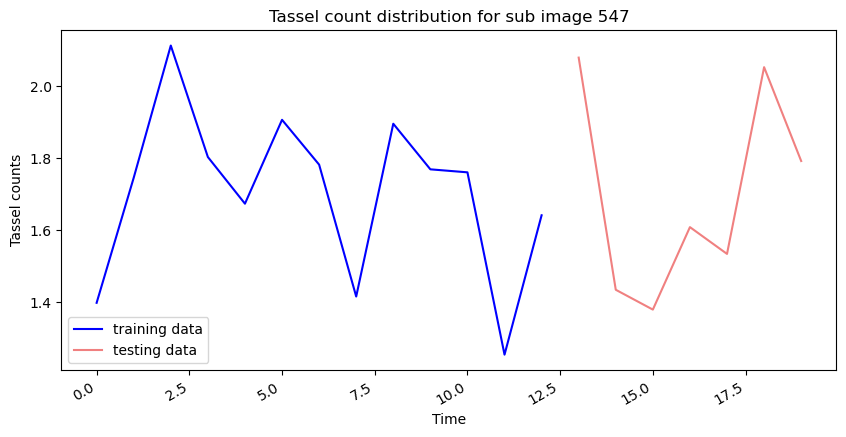

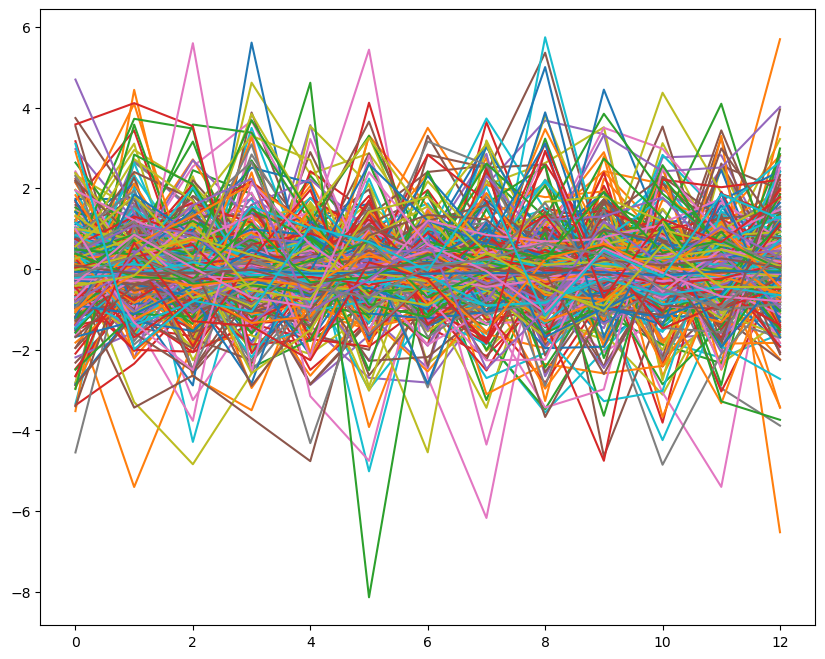

2025-09-24 22:04:53.905424: I external/local_xla/xla/service/service.cc:168] XLA service 0x561c70ae49d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-09-24 22:04:53.905476: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-09-24 22:04:54.431616: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator chain_of_default_joint_bijector_of_restructure/ldj_reduction_ndims/assert_equal_1/Assert/Assert
2025-09-24 22:04:54.440954: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator chain_of_default_joint_bijector_of_restructure_of_jointmap_of_reshape_and_reshape_1_and_reshape_2_and_reshape_3_and_reshape_4/ldj_reduction_ndims_5/assert_equal_1/Assert/Assert
2025-09-24 22:04:54.445196: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-

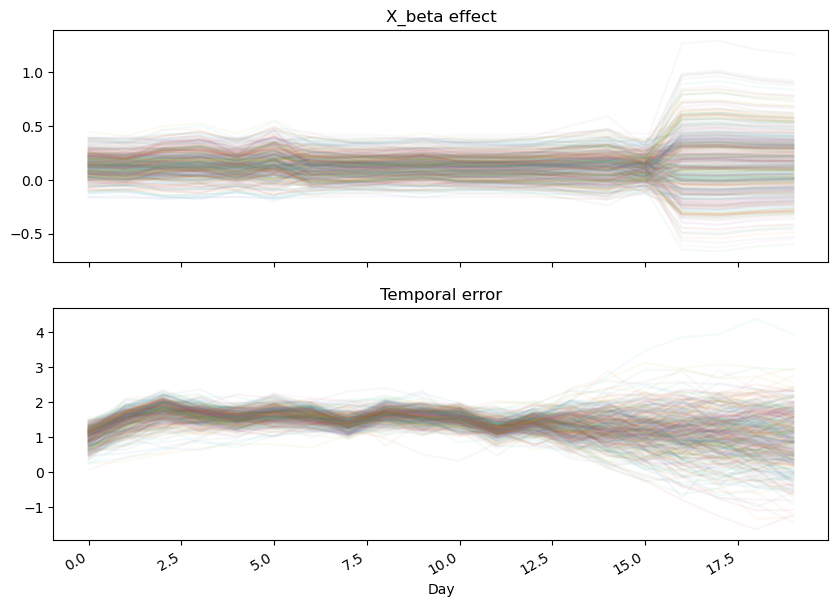

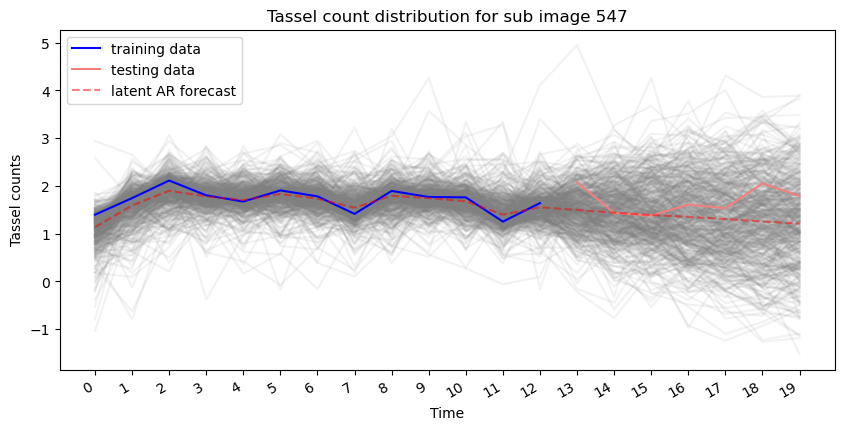

(4, 1000)
(4, 1000)
(4, 1000)
(4, 1000, 33)


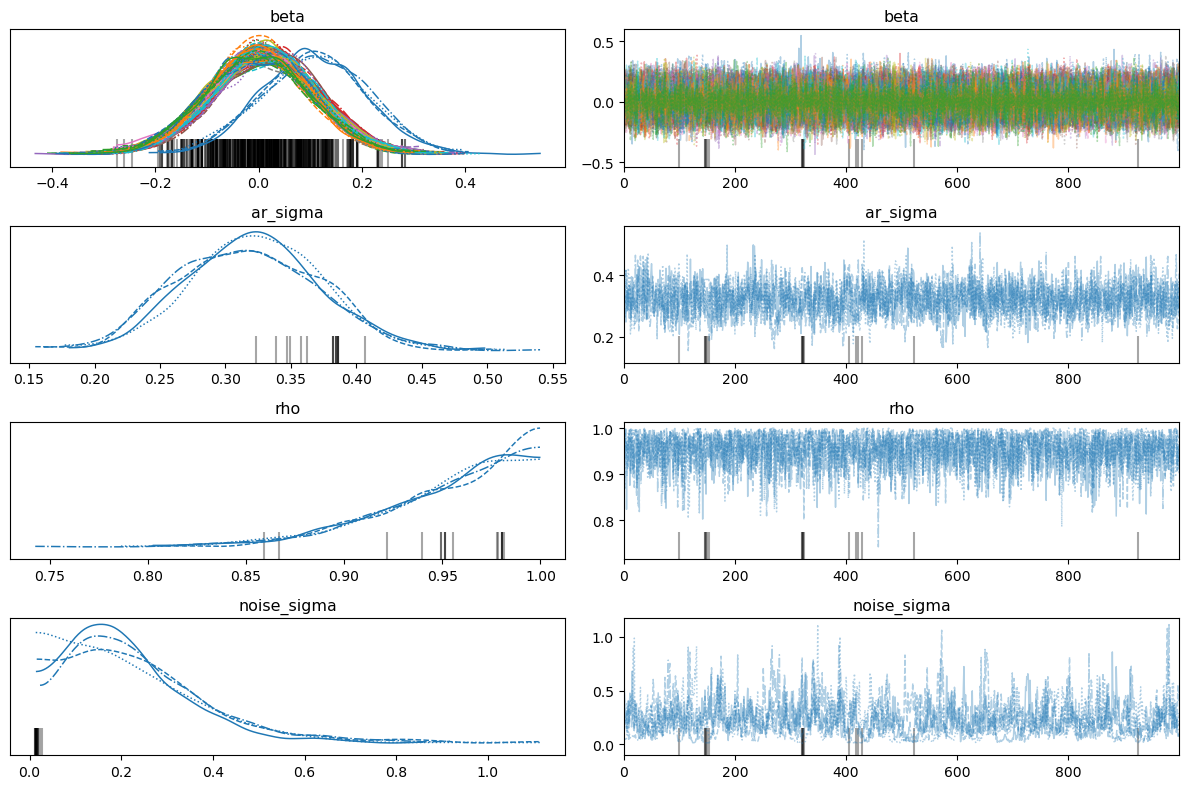

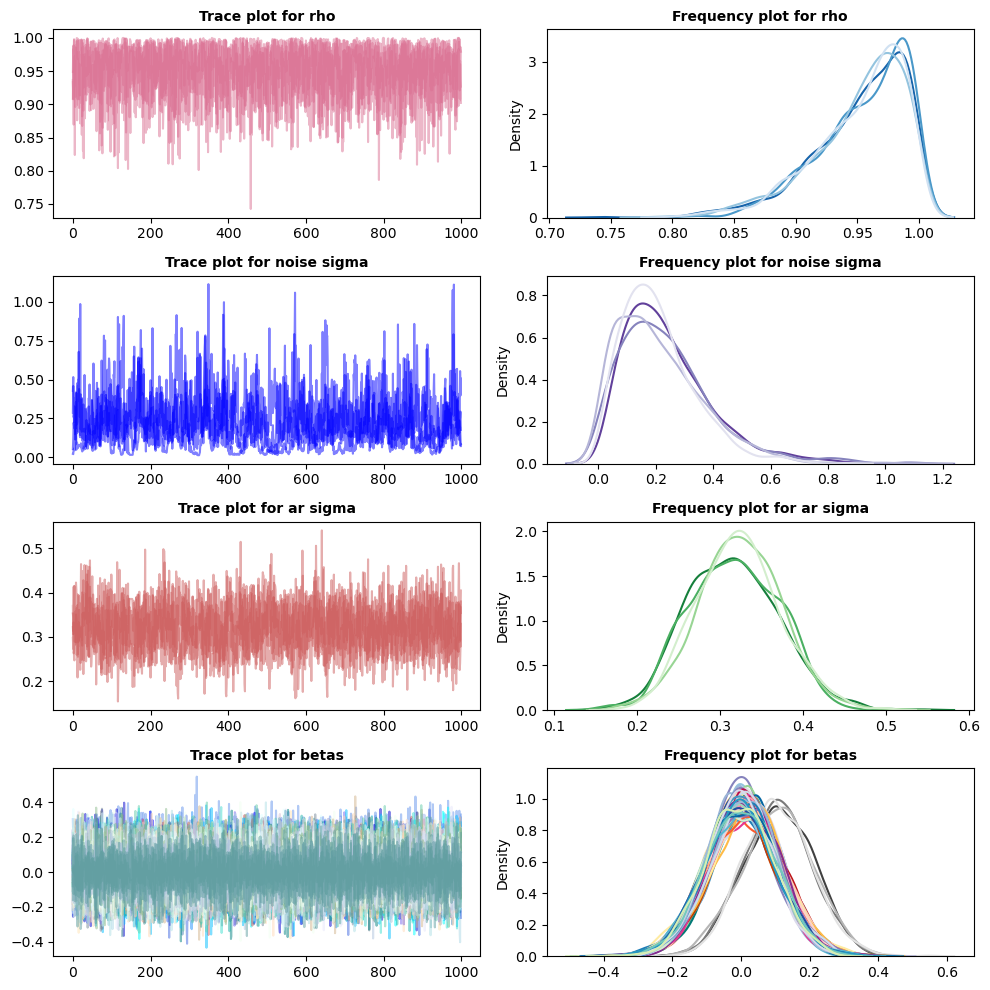

(1000, 4, 20) (20,)
CPU times: user 45.2 s, sys: 16.7 s, total: 1min 1s
Wall time: 45 s


In [35]:
%%time
catch_df_here = fit_Bayes_TS_model(sub_image_files[0], forecasting_steps, path_to_precessed_dfs, sub_image_numbers, n_features, figure_folder_path,
        forecasts_folder_path, nchains
    )

In [36]:
catch_df_here

,True_value,Forecasted_value
0,2.079523,1.496263
1,1.433502,1.439708
2,1.378286,1.390418
3,1.607816,1.353086
4,1.533289,1.306649
5,2.052938,1.255756
6,1.791789,1.210375


In [37]:
# cool, get the forecasts again?

In [38]:
# we may first need to figure out the path where the chains of forecasted values are stored?
main_file_path = 'data/BLAR_implementation/Block_0103/forecasted_counts'
np_file_name = 'all_forecasts_sub_547.npy'

In [39]:
# load just the first file
sub_1104_forecasts = np.load(os.path.join(main_file_path, np_file_name))

In [40]:
sub_1104_forecasts.shape

(1000, 4, 7)

In [41]:
# Okay, so for the subwindow 273 -  this file seem to have all the 1000 values in the 4 chains for all the test time points in the sequence

In [42]:
# transform these values?
sub_1104_forecasts = np.exp(sub_1104_forecasts) - 1

In [43]:
sub_1104_forecasts.min(), sub_1104_forecasts.max()

(-0.8686641, 139.95412)

In [44]:
# get rid of anything below zero?
sub_1104_forecasts[sub_1104_forecasts < 0] = 0

In [45]:
sub_1104_forecasts.min(), sub_1104_forecasts.max()

(0.0, 139.95412)

In [46]:
# cool -  what does these values mean?

In [47]:
# try averaging the forecasted values along the 0th and 1st axis?

In [48]:
sub_1104_forecasts_averged = np.mean(sub_1104_forecasts, axis = (0,1))

In [49]:
sub_1104_forecasts_averged

array([4.0254626, 3.9876485, 3.952112 , 4.186947 , 4.132415 , 4.0399847,
       4.0014644], dtype=float32)

In [50]:
sub_1104_forecasts_averged.shape

(7,)

In [51]:
# sanity check

In [52]:
# sanity check
for i in range(sub_1104_forecasts.shape[-1]):
    track = sub_1104_forecasts[:,:,i]
    print(np.mean(track))

4.0254664
3.987641
3.9521232
4.186947
4.1324162
4.0399804
4.0014577


In [53]:
# might it be better to have the true counts as well? For comparison? I think so?

In [54]:
# true values
np.exp(catch_df_here['True_value'].values) - 1

array([7.00065239, 3.19335798, 2.96809261, 3.9918987 , 3.6333897 ,
       6.79075292, 5.00017537])

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

In [56]:
rmse = np.sqrt(mean_squared_error(np.exp(catch_df_here['True_value'].values) - 1, sub_1104_forecasts_averged))
rmse

1.6605577771342062

In [57]:
mae = mean_absolute_error(np.exp(catch_df_here['True_value'].values) - 1, sub_1104_forecasts_averged)
mae

1.3138645897872476